In [1]:
import openai
from openai import OpenAI
import cv2
from moviepy.editor import VideoFileClip
import base64
import os
from IPython.display import Image, display, Audio, Markdown
import time
from pytube import YouTube

https://cookbook.openai.com/examples/gpt4o/introduction_to_gpt4o#base64-image-processing

In [2]:
client = OpenAI()
MODEL="gpt-4o"

In [ ]:
# Example 1: Simple Text Input

completion = client.chat.completions.create(
  model=MODEL,
  messages=[
    {"role": "system", "content": "You are a helpful assistant. Help me with my math homework!"}, # <-- This is the system message that provides context to the model
    {"role": "user", "content": "Hello! Could you solve 2+2?"}  # <-- This is the user message for which the model will generate a response
  ]
)

print(completion.choices[0].message.content)

In [ ]:
# Example 2.1: Image Processing (local)

IMAGE_PATH = "data/triangle.png"

display(Image(IMAGE_PATH))

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)

response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant that responds in Markdown. Help me with my math homework!"},
        {"role": "user", "content": [
            {"type": "text", "text": "What's the area of the triangle?"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ],
    temperature=0.0,
)

print(response.choices[0].message.content)

In [ ]:
# Example 2.2: Image Processing (URL)

image_url = input('Image URL: ')

response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant that responds in Markdown. Please describe the content of the image I provide."},
        {"role": "user", "content": [
            {"type": "text", "text": "Describe the content of this image in detail."},
            {"type": "image_url", "image_url": {"url": image_url}}
        ]}
    ],
    temperature=0.0,
)

print(response.choices[0].message.content)

# Example 3: Video Processing

In [3]:
video_url = 'https://www.youtube.com/watch?v=PARPlUknz-8'

!rm output.mp4

yt = YouTube(video_url)
stream = yt.streams.get_lowest_resolution()
stream.download(output_path='.', filename='output.mp4')
print('Video downloaded successfully.')

Video downloaded successfully.


In [ ]:
# Visual Summary (small videos)

VIDEO_PATH = "output.mp4"

def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # Extract audio from video
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")
    clip.audio.close()
    clip.close()

    print(f"Extracted {len(base64Frames)} frames")
    print(f"Extracted audio to {audio_path}")
    return base64Frames, audio_path

base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)

# Display the video and audio
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

Audio(audio_path)

MoviePy - Writing audio in output.mp3


MoviePy - Done.
Extracted 527 frames
Extracted audio to output.mp3


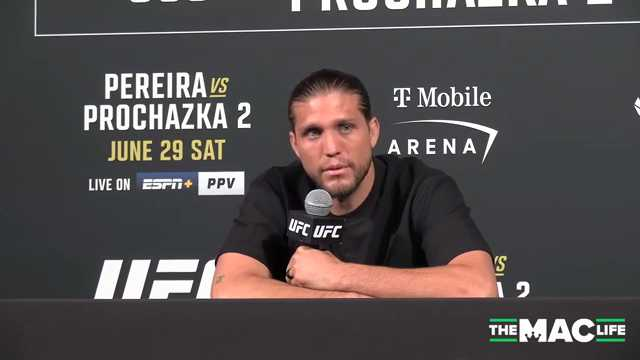

Processing chunk 1/6...
Summary for chunk 1:
The video appears to be a UFC press conference or media event. The individual in the frames is seated at a table with a microphone, and the backdrop features promotional materials for a UFC event, specifically "Pereira vs Prochazka 2" scheduled for June 29, with ESPN+ and PPV branding.

### Summary:
- **Event**: UFC press conference for "Pereira vs Prochazka 2"
- **Date**: June 29
- **Broadcast**: ESPN+ and PPV
- **Content**: The individual at the table engages with the media, likely answering questions regarding the upcoming event or related topics. The person appears attentive and responsive throughout the conference.

### Key Points:
- The event is promoting a significant UFC fight.
- The individual is likely a fighter or a representative involved in the event.
- The backdrop and banners provide details on the date and broadcast partners.
Processing chunk 2/6...
Summary for chunk 2:
### Video Summary

The video appears to be a press confe

In [11]:
# Visual Summary (larger videos w/ chunking)

VIDEO_PATH = 'output.mp4'

# Function to extract frames and audio from the video
def process_video(video_path, seconds_per_frame=2):
    base64_frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame = 0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame, [cv2.IMWRITE_JPEG_QUALITY, 50])  # Compress image quality
        base64_frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # Extract audio from video
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")
    clip.audio.close()
    clip.close()

    print(f"Extracted {len(base64_frames)} frames")
    print(f"Extracted audio to {audio_path}")
    return base64_frames, audio_path

# Function to split a list into chunks
def chunk_list(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]

# Extract frames and audio from the video
base64_frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=2)

# Define chunk size

CHUNK_SIZE = 100  # Number of frames per chunk

# Split the frames into chunks
frame_chunks = list(chunk_list(base64_frames, CHUNK_SIZE))

# Display the first chunk of frames for context
display_handle = display(None, display_id=True)
for img in frame_chunks[0]:  # Display only the first chunk of frames
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))

# Function to process and summarize each chunk with OpenAI
def summarize_chunk(frames_chunk):
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You are generating a video summary. Please provide a detailed summary of the video. Respond in Markdown."},
            {"role": "user", "content": [
                "These are some frames from the video.",
                *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, frames_chunk)
                ],
            }
        ],
        temperature=0.7,
    )
    return response.choices[0].message.content

# Collect summaries of each chunk
chunk_summaries = []

# Process each chunk and collect the summaries
for i, chunk in enumerate(frame_chunks):
    print(f"Processing chunk {i+1}/{len(frame_chunks)}...")
    summary = summarize_chunk(chunk)
    print(f"Summary for chunk {i+1}:\n{summary}")
    chunk_summaries.append(summary)

# Create a final summary of all chunk summaries
final_summary_response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant. Please provide a comprehensive summary of the following chunk summaries. Respond in Markdown."},
        {"role": "user", "content": "Here are the summaries of the video chunks:\n\n" + "\n\n".join(chunk_summaries)}
    ],
    temperature=0.0,
)

# Print the final summary
final_summary = final_summary_response.choices[0].message.content
print(f"Final Summary:\n{final_summary}")

In [18]:
# Audio Summary

# {audio} input for GPT-4o isn't currently available but will be coming soon!
# For now, we use our existing whisper-1 model to process the audio

audio_path = 'output.mp3'

# Transcribe the audio
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=open(audio_path, "rb"),
) 
## OPTIONAL: Uncomment the line below to print the transcription
# print("Transcript: ", transcription.text + "\n\n")

response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""
    You are generating a detailed summary of a fighter interview. Focus on the following aspects:
    - Fighter's demeanor and energy
    - Key statements and quotes
    - Important topics discussed related to the upcoming fight
    - Any notable expressions or gestures
    - Information that could provide a betting or handicapping edge
    Be thorough and summarize it all from start to finish. Respond in Markdown."""},
    {"role": "user", "content": [{"type": "text", "text": f"The audio transcription is: {transcription.text}"}],}],
    temperature=0.8,
)
print(response.choices[0].message.content)

# Fighter Interview Summary - Brian

## Demeanor and Energy
Brian's demeanor throughout the interview is a mix of reflective and determined. He displays a calm energy, showing a deep sense of purpose and readiness for the upcoming fight. Despite the short notice, he exudes confidence and resilience.

## Key Statements and Quotes
- **On Short Notice Opportunity**: "It feels good, man. It's something that I'm not used to. It feels like new again."
- **On Last Performance**: "There was a lot of redemption that I had to get done. It was the perfect outcome."
- **On Opponent Diego**: "At the end of the day, there's just the facts. I faced who's who in their prime at the best of their peak. But it's also good to respect Diego for who he is and what he brings to the table."
- **On Stakes of the Fight**: "For me, not much. Like crazy stakes, right? For him, obviously, it puts him in perfect title contention."
- **On Preparing for the Fight**: "I'm as good as it's going to get for a two-week no

In [ ]:
# Audio + Visual Summary

response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""You are generating a video summary. Create a summary of the provided video and its transcript. Respond in Markdown"""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
],
    temperature=0,
)
print(response.choices[0].message.content)

-----

### Question and Answering Examples

1. **Visual QA Code:**
```python
question = "Why did Sam Altman have an example about raising windows and turning the radio on?"

response = client.chat_completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "Answer the question using the video."},
        {"role": "user", "content": base64_frames, "type": "image_url"},
        {"role": "user", "content": question}
    ],
    temperature=0.0
)

print(response.choices[0].message.content)
```

2. **Audio QA Code:**
```python
response = client.chat_completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "Answer the question using the transcription."},
        {"role": "user", "content": transcription.text},
        {"role": "user", "content": question}
    ],
    temperature=0.0
)

print(response.choices[0].message.content)
```

3. **Audio + Visual QA Code:**
```python
response = client.chat_completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "Answer the question using the video and transcription."},
        {"role": "user", "content": base64_frames, "type": "image_url"},
        {"role": "user", "content": transcription.text},
        {"role": "user", "content": question}
    ],
    temperature=0.0
)

print(response.choices[0].message.content)
```

----

### Conclusion

Integrating multiple input modalities (audio, visual, and textual) significantly enhances the model's performance on various tasks. Currently, GPT-4O supports text and image inputs, with audio capabilities coming soon.

For full examples and detailed documentation, you can refer to the [OpenAI GPT-4O Cookbook](https://cookbook.openai.com/examples/gpt4o/introduction_to_gpt4o).